In [47]:
import ROOT as r
import math
import array
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

#______________Add include directory_______________
current_dir = os.getcwd()
include_dir = os.path.join(current_dir, '../include')
sys.path.insert(0, include_dir)
#__________________________________________________

import CONFIG
import DBPARSE
from UTILITIES import *
from SIMFITS import DistributionFits
from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.optimize import curve_fit
from scipy.integrate import quad

In [48]:
pas="1"
config="4"


In [49]:
W2min=CONFIG.Function_JSON("W2min",f"../config/cuts{config}.cfg")
W2max=CONFIG.Function_JSON("W2max",f"../config/cuts{config}.cfg")
dxmin=CONFIG.Function_JSON("dxmin",f"../config/cuts{config}.cfg")
dxmax=CONFIG.Function_JSON("dxmax",f"../config/cuts{config}.cfg")
dymin=CONFIG.Function_JSON("dymin",f"../config/cuts{config}.cfg")
dymax=CONFIG.Function_JSON("dymax",f"../config/cuts{config}.cfg")
dybgmin=CONFIG.Function_JSON("dybgmin",f"../config/cuts{config}.cfg")
dybgmax=CONFIG.Function_JSON("dybgmax",f"../config/cuts{config}.cfg")
sigmacoin=CONFIG.Function_JSON("sigmacoin",f"../config/cuts{config}.cfg")
coin=CONFIG.Function_JSON(f"GEN{config}","../config/coin.cfg")
coinmin=coin[0]-sigmacoin*coin[1]
coinmax=coin[0]+sigmacoin*coin[1]
print(f'W2min: {W2min}')
print(f'W2max: {W2max}')
print(f'dxmin: {dxmin}')
print(f'dxmax: {dxmax}')
print(f'dymin: {dymin}')
print(f'dymax: {dymax}')
print(f'dybgmin: {dybgmin}')
print(f'dybgmax: {dybgmax}')
print(f'Coin Min: {coinmin} Coin Max: {coinmax}')

W2min: -1
W2max: 2
dxmin: -0.303
dxmax: 0.306
dymin: -0.84
dymax: 0.984
dybgmin: -1.2
dybgmax: 1.2
Coin Min: 83.00159 Coin Max: 102.07001


In [50]:
def coincidence(config):
    r.gErrorIgnoreLevel = r.kError  # Suppress Info and Warning messages

    gStyle.SetOptStat(0)
    gStyle.SetOptFit(1)

    #_____bring in config values______#
    coinVector=CONFIG.Function_JSON("GEN"+config,"../config/coin.cfg")
    he3spot=CONFIG.Function_JSON("GEN"+config+"He3","../config/spotsize.cfg")
    he3spotsim=CONFIG.Function_JSON("GEN"+config+"He3sim","../config/spotsize.cfg")
    
    #here, set coincidence cut and spot cut values
    coinSigma=3
    coin_low=coinVector[0]-coinSigma*coinVector[1]
    coin_high=coinVector[0]+coinSigma*coinVector[1]   
    #-------------------------------------
    rootfilenp = (f"../outfiles/Pass1/QE_data_GEN{config}_sbs100p_nucleon_np_model2.root")
    rootfilep = (f"../outfiles/Pass1/QE_sim_GEN{config}_sbs100p_nucleon_np_model2.root")
    if config == "4":
        config = "4b"
    
    C = TChain("Tout")
    B = TChain("Tout")
    
    C.Add(rootfilenp)
    B.Add(rootfilep)

    dx_p, dy_p, W2_p, coin_p,fnucl  = array.array('d', [0]),array.array('d', [0]), array.array('d', [0]), array.array('d', [0]), array.array('d', [0])
    dx_np, dy_np, W2_np, coin_np, weight = array.array('d', [0]), array.array('d', [0]), array.array('d', [0]), array.array('d', [0]), array.array('d', [0])
    helicity_p, IHWP_p, runnum_p = array.array('i', [0]), array.array('i', [0]), array.array('i', [0])
    helicity_np, IHWP_np, runnum_np= array.array('i', [0]), array.array('i', [0]), array.array('i', [0])
    
    # Disable all branches initially
    C.SetBranchStatus("*", 0)
    B.SetBranchStatus("*", 0)

    # Enable specific branches
    branches = ["dx", "dy", "W2", "helicity", "IHWP", "runnum", "coinCut", "coin_time"]
    b2=["dx", "dy", "W2"]
    for branch in branches:
        C.SetBranchStatus(branch, 1)
    for branch in b2:
        B.SetBranchStatus(branch, 1)

    B.SetBranchStatus("weight", 1)
    B.SetBranchStatus("fnucl",1)
    # Set branch addresses
    C.SetBranchAddress("dx", dx_np)
    B.SetBranchAddress("dx", dx_p)
    C.SetBranchAddress("dy", dy_np)
    B.SetBranchAddress("dy", dy_p)
    C.SetBranchAddress("W2", W2_np)
    B.SetBranchAddress("W2", W2_p)
    C.SetBranchAddress("helicity", helicity_np)
    #B.SetBranchAddress("helicity", helicity_p)
    C.SetBranchAddress("IHWP", IHWP_np)
    #B.SetBranchAddress("IHWP", IHWP_p)
    C.SetBranchAddress("coin_time", coin_np)
    #B.SetBranchAddress("coin_time", coin_pp)
    C.SetBranchAddress("runnum", runnum_np)
    #B.SetBranchAddress("runnum", runnum_p)
    B.SetBranchAddress("weight", weight)
    B.SetBranchAddress("fnucl", fnucl)
    
    # Assuming the variables are already defined or loaded from the ROOT file
    
    nbins = 200
    xmin, xmax = 0, 200
    
    hcoin = TH1F("hcoin","Coincidence Time ;Time (ns);Entries", nbins, xmin, xmax)
    hcoin_minus = TH1F("hcoin_minus","Coincidence Time -;Time (ns);Entries", nbins, xmin, xmax)
    hcoin_plus = TH1F("hcoin_pluys","Coincidence Time + ;Time (ns);Entries", nbins, xmin, xmax)

    
    # JSONManager part is omitted for now

    nEntries_np = C.GetEntries()
  
    
    #spot imports for dx,dy high and low
    
    hiydata=he3spot[1];
    lowydata=he3spot[0];
    hixdatan=he3spotsim[7];
    lowxdatan=he3spotsim[6];
    hixdatap=he3spotsim[5];
    lowxdatap=he3spotsim[4];
    
    # Data loop

    
    for i in range(nEntries_np):
        C.GetEntry(i)
        #____________CUTS_______________________________      
        ycut = dymin < dy_np[0] < dymax
        bgycut=dybgmin<dy_np[0]<dybgmax
        coin_cut = coinmin < coin_np[0] < coinmax
        W2cut=W2min < W2_np[0] < W2max
        xcutn = dxmin < dx_np[0] < dxmax
        #________________________________________________ 

        if IHWP_np[0] == 1:
            helicity_np[0] *= -1
        elif IHWP_np[0] == -1:
            helicity_np[0] *= 1
        else:
            continue
        pcut=dx_np[0]<hixdatap and dx_np[0]>lowxdatap and dy_np[0]<hiydata and dy_np[0]>lowydata
        ncut=dx_np[0]<hixdatan and dx_np[0]>lowxdatan and dy_np[0]<hiydata and dy_np[0]>lowydata
        
        ycut = lowydata < dy_np[0] < hiydata
        
        if W2cut and ycut and xcutn:
            hcoin.Fill(coin_np[0])
            
            if helicity_np[0] == 1:
                hcoin_plus.Fill(coin_np[0])
            if helicity_np[0] == -1:
                hcoin_minus.Fill(coin_np[0])
        

    
    return Function_HIST2NP(hcoin), Function_HIST2NP(hcoin_plus),Function_HIST2NP(hcoin_minus)


In [51]:
coin,coinminus,coinplus=coincidence(config)

Error in <THashList::Delete>: A list is accessing an object (0x96e6bc0) already deleted (list name = THashList)


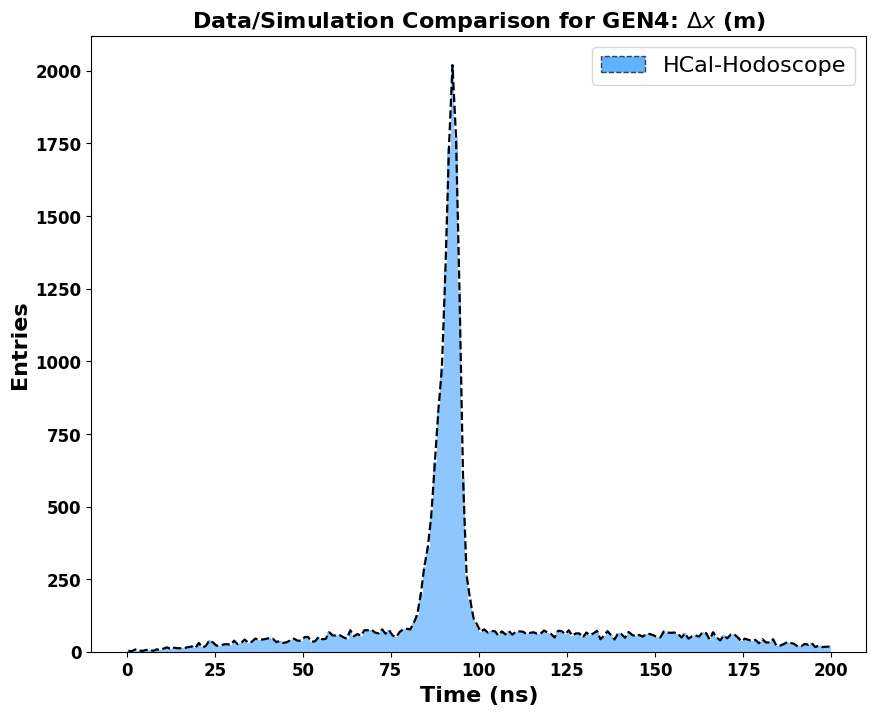

In [52]:
bin_centers,bin_contents=coin

plt.figure(figsize=(10,8))
lw=1.6
fs=16
fw='bold'

#____________Total Coincidence___________________________________________________________________________________________
bin_centers,bin_contents=coin
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.5,color='dodgerblue',label="Total Fit = bg+simN+simP")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
#___________________________________________________________________________________________________________
legend_elements = [
    Patch(facecolor='dodgerblue', edgecolor='black', linestyle='--', label='HCal-Hodoscope',alpha=.7)]
plt.title(f'Data/Simulation Comparison for GEN{config}: $\Delta x$ (m)',fontsize=fs,fontweight=fw)
plt.legend(handles=legend_elements,loc='upper right',fontsize=fs)
plt.xticks(fontsize=fs-4, fontweight=fw)
plt.yticks(fontsize=fs-4, fontweight=fw)
plt.xlabel('Time (ns)',fontsize=fs,fontweight=fw)
plt.ylabel('Entries',fontsize=fs,fontweight=fw)

plt.show()

# Fit and Determine Fraction of Accidentals in Signal

Config Paste [Mean,Sigma]: [92.05770852071255,2.519169455015059]
Total Events: 11509.929007624165 Background: 797.3127426489704 Fraction - f_Acc: 0.069


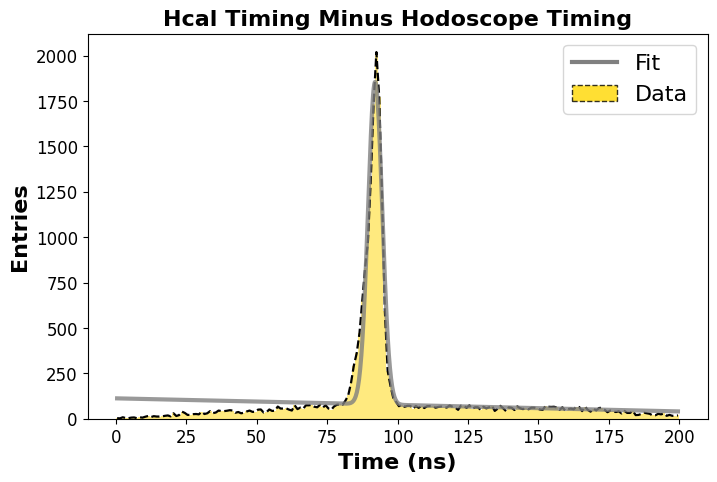

In [53]:



fit_range_min = 60
fit_range_max = 125
mask = (bin_centers >= fit_range_min) & (bin_centers <= fit_range_max)
fit_bin_centers = bin_centers[mask]
fit_bin_contents = bin_contents[mask]


def fit_function(x, a, mu, sigma, c, d):
    gauss = a * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    pol1 = c + d * x
    return gauss + pol1

# Initial parameter guesses
initial_params = [30000, 90, 10, 50, -0.1]

# Assuming bin_centers and bin_contents are already defined numpy arrays
# Example: bin_centers = np.array([...]), bin_contents = np.array([...])

# Fit the data
params, covariance = curve_fit(fit_function, fit_bin_centers, fit_bin_contents, p0=initial_params)

# Extract fitted parameters
a, mu, sigma, c, d = params

print(f"Config Paste [Mean,Sigma]: [{mu},{sigma}]")

# Define the polynomial background function
def pol1(x, c, d):
    return c + d * x

# Calculate the integral of the polynomial background
x_min = mu - 2 * sigma
x_max = mu + 2 * sigma
background_events, _ = quad(pol1, x_min, x_max, args=(c, d))

# Calculate the integral of the total fit function
total_events, _ = quad(fit_function, x_min, x_max, args=(a, mu, sigma, c, d))

# Calculate the ratio
ratio = np.round(background_events / total_events,3)

print(f"Total Events: {total_events} Background: {background_events} Fraction - f_Acc: {ratio}")

# Plotting the data and the fit

plt.figure(figsize=(8,5))

#____________Total Coincidence___________________________________________________________________________________________
bin_centers,bin_contents=coin
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.5,color='gold',label="Total Fit = bg+simN+simP")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
#___________________________________________________________________________________________________________

x_fit = np.linspace(min(bin_centers), max(bin_centers), 1000)
plt.plot(x_fit, fit_function(x_fit, *params), 'grey',alpha=.8,linewidth=3, label='Fit')

legend_elements = [
     Line2D([0], [0], color='grey', linewidth=3, linestyle='-', label='Fit'),
    Patch(facecolor='gold', edgecolor='black', linestyle='--', label='Data',alpha=.8)]
plt.title('Hcal Timing Minus Hodoscope Timing',fontsize=fs,fontweight=fw)

plt.legend(handles=legend_elements,loc='upper right',fontsize=fs)
plt.xticks(fontsize=fs-4)
plt.yticks(fontsize=fs-4)
plt.xlabel('Time (ns)',fontsize=fs,fontweight=fw)
plt.ylabel('Entries',fontsize=fs,fontweight=fw)





plt.show()

# Calculate Asymmetry

## CoinPlus

In [61]:
bin_centers,bin_contents=coinplus
if config=="2":
    count_ranges = [(0, 90), (115, 200)]
if config=="3":
    count_ranges = [(0, 82), (107, 200)]
count_ranges=[(0, coinmin), (coinmax, 200)]

# Initialize total counts
total_counts = 0

# Sum the bin contents within the specified ranges
for count_range_min, count_range_max in count_ranges:
    count_mask = (bin_centers >= count_range_min) & (bin_centers <= count_range_max)
    count_bin_contents = bin_contents[count_mask]
    total_counts += np.sum(count_bin_contents)

print(f"Total counts between 30 and 60 and 125 and 175: {total_counts}")
countP=total_counts

Total counts between 30 and 60 and 125 and 175: 3995.0


## CoinMinus

In [62]:

bin_centers,bin_contents=coinminus


# Initialize total counts
total_counts = 0

# Sum the bin contents within the specified ranges
for count_range_min, count_range_max in count_ranges:
    count_mask = (bin_centers >= count_range_min) & (bin_centers <= count_range_max)
    count_bin_contents = bin_contents[count_mask]
    total_counts += np.sum(count_bin_contents)

print(f"Total counts between 30 and 60 and 125 and 175: {total_counts}")
countM=total_counts

Total counts between 30 and 60 and 125 and 175: 4120.0


## Asymmetry

In [63]:
A=np.round(100*abs((countP-countM)/(countP+countM)),3)
print("Asymmetry: "+str(A))

Asymmetry: 1.54


# Create Visual 

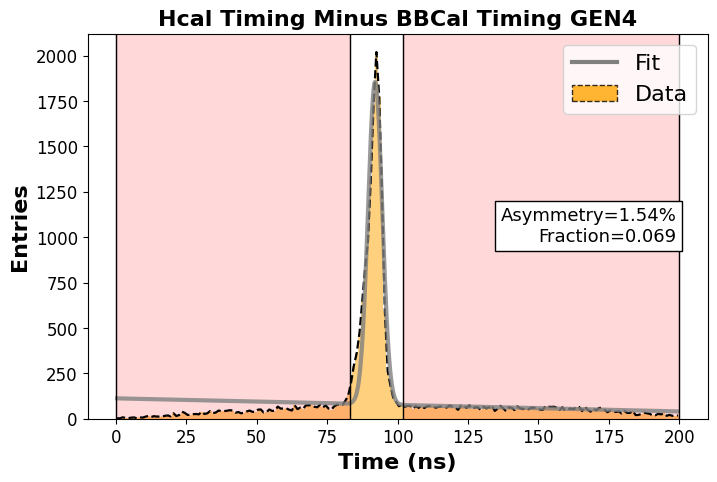

In [64]:
plt.figure(figsize=(8,5))

#____________Total Coincidence___________________________________________________________________________________________
bin_centers,bin_contents=coin
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.5,color='orange',label="Total Fit = bg+simN+simP")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
#___________________________________________________________________________________________________________

x_fit = np.linspace(min(bin_centers), max(bin_centers), 1000)
plt.plot(x_fit, fit_function(x_fit, *params), 'grey',alpha=.8,linewidth=3, label='Fit')

legend_elements = [
     Line2D([0], [0], color='grey', linewidth=3, linestyle='-', label='Fit'),
    Patch(facecolor='orange', edgecolor='black', linestyle='--', label='Data',alpha=.8)]
plt.title(f'Hcal Timing Minus BBCal Timing GEN{config}',fontsize=fs,fontweight=fw)

plt.legend(handles=legend_elements,loc='upper right',fontsize=fs)
plt.xticks(fontsize=fs-4)
plt.yticks(fontsize=fs-4)
plt.xlabel('Time (ns)',fontsize=fs,fontweight=fw)
plt.ylabel('Entries',fontsize=fs,fontweight=fw)

for count_range_min, count_range_max in count_ranges:
    plt.axvspan(count_range_min, count_range_max, color='red', alpha=0.15)
    plt.axvline(count_range_min, color='black', linestyle='-', linewidth=1)
    plt.axvline(count_range_max, color='black', linestyle='-', linewidth=1)
textstr = 'Asymmetry='+str(A)+'%\nFraction='+str(ratio)
props = dict(boxstyle='square', facecolor='white', edgecolor='black')
plt.text(0.95, 0.5, textstr, transform=plt.gca().transAxes, fontsize=13,
         verticalalignment='center', horizontalalignment='right', bbox=props)



plt.savefig(f"../plots/CORRECTIONS_Accidental{config}")

In [65]:
A=(countP-countM)/(countP+countM)
A

-0.015403573629081947

In [66]:
ratio

0.069

In [67]:
np.save(f'CorrectionArrays/Pass{pas}/facc{config}.npy',np.array(ratio))
np.save(f'CorrectionArrays/Pass{pas}/Aacc{config}.npy',np.array(A))